# Effect of weather on Formula 1, a broad analysis

## Introduction

The objective of this project is to determine whether or not variables such as temperature, track temperature and humidity etc may effect track fastest lap speeds, times and total laps completed.

Data is analysed from five tracks over four different seasons, from 2016 to 2019.

* Silverstone, Britain
* Albert Park, Melbourne
* Interlagos, Brazil
* Catalunya, Spain
* De spa, Belgium

Table of contents:

Overview section
* Data Preparation
* Some other section
* Another section

## Data Preparation

### Preliminaries

In [337]:
# Module Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm

In [454]:
# Read invididual data files
races = pd.read_csv('data/formula-1/races.csv', sep = ',')
results = pd.read_csv('data/formula-1/results.csv', sep = ',')
track_weather = pd.read_csv('data/track_weather.csv', sep = ',')

# Merge data (on raceID & date)
data_raw = races.merge(results, on = 'raceId').merge(track_weather, on = 'date')

# Clean data (4620, 20) 204
df = data_raw.drop(columns = ['url', 'year', 'round', 'name', 'time_x', 'constructorId', 'number', 'grid', 'position', 'track', 'positionOrder', 'positionText', 'resultId', 'time_y'])

# Remove '\N' characters (4416, 20)
df = df.replace(r'\\N','null', regex=True) 
df = df.loc[df['fastestLapSpeed'] != 'null']
df['fastestLapSpeed'] = df['fastestLapSpeed'].astype(float)


fastestLapSpeed = df.groupby(['circuitId', 'date'])['fastestLapSpeed'].mean().reset_index()
#fastestLapTime = df.groupby(['circuitId', 'date'])['fastestLapTime'].mean().reset_index()

df = fastestLapSpeed.merge(track_weather, on = 'date')

rain_desc = ["rain", "shower", "drizzle", "wet"]
years = ["2016"]
tracks = ["monza", "silverstone", "de-spa", "fuji", "albert-park", "interlagos"]

df['rain'] = np.where(df['weather'].str.contains('|'.join(rain_desc)), 1, 0)


#df = df.loc[df['track'] == "de-monaco"]
df = df.loc[df['track'].str.contains('|'.join(tracks))]




In [456]:
df.sample(n = 10, random_state = 999)

,circuitId,date,fastestLapSpeed,track,local_time,weather,temp,track_temp,humidity,air_pressure,wind_speed,wind_direction,rain
2,1,2009-03-29,214.918895,albert-park,17:00:00,sunny,21.0,27.0,65.0,1020.0,5.0,south,0
156,18,2010-11-07,205.372625,interlagos,14:00:00,sunny,24.0,49.0,62.0,924.0,6.0,southeast,0
128,14,2010-09-12,242.850318,monza,14:00:00,sunny,25.0,35.0,43.0,996.0,2.0,south,0
130,14,2012-09-09,234.247583,monza,14:00:00,slightly cloudy,28.0,40.0,33.0,995.0,1.5,southwest,0
157,18,2011-11-27,199.549333,interlagos,14:00:00,slightly cloudy,24.0,42.0,58.0,924.0,4.5,southeast,0
119,13,2014-08-24,221.581050,de-spa,14:00:00,cloudy,14.0,26.0,62.0,970.0,2.0,northeast,0
120,13,2015-08-23,219.946444,de-spa,14:00:00,cloudy,23.0,35.0,42.0,958.0,3.5,northwest,0
83,9,2009-06-21,226.025200,silverstone,13:00:00,cloudy,16.0,28.0,57.0,1007.0,3.5,northwest,0
90,9,2016-07-10,210.161636,silverstone,13:00:00,cloudy / rain at the beginning,19.0,25.0,72.0,987.0,3.5,southwest,1
10,1,2017-03-26,215.679800,albert-park,16:00:00,slightly cloudy,24.0,34.0,69.0,1010.0,2.0,northwest,0


## Data Plots

### Basic Scatter Plots

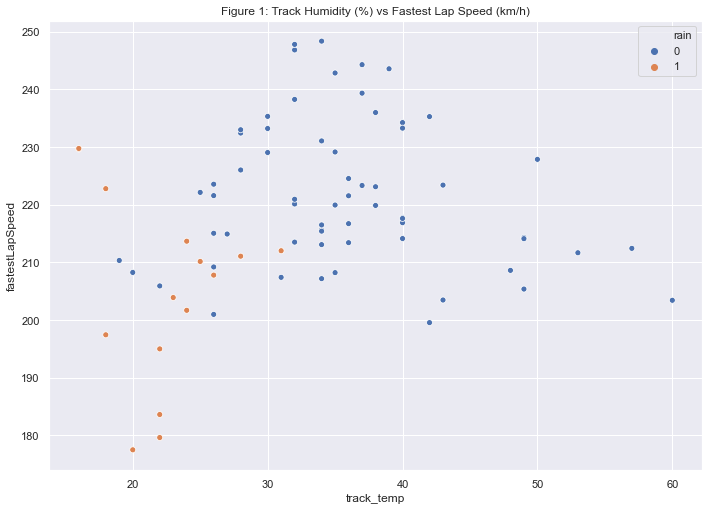

In [457]:
# create scatterplot 
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(df['track_temp'], df['fastestLapSpeed'], hue=df['rain'])
plt.title('Figure 1: Track Humidity (%) vs Fastest Lap Speed (km/h)')
plt.show();




In [458]:
print("temp: " + str((df.temp).corr(df.fastestLapSpeed)))
print("track_temp: " + str((df.track_temp).corr(df.fastestLapSpeed)))
print("humidity: " + str((df.humidity).corr(df.fastestLapSpeed)))
print("air_pressure: " + str((df.air_pressure).corr(df.fastestLapSpeed)))
print("wind_speed: " + str((df.wind_speed).corr(df.fastestLapSpeed)))       
print("rain: " + str((df.rain).corr(df.fastestLapSpeed)))       

temp: 0.1541045440049569
track_temp: 0.1634078088887693
humidity: -0.4293352792541054
air_pressure: 0.28021667236425524
wind_speed: -0.3658114200443084
rain: -0.444803947865063


In [459]:
# fit linear regression
X = df[['track_temp', 'humidity', 'rain']]
Y = df['fastestLapSpeed']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn

new_track_temp = 24
new_humidity = 80
new_rain = 0
print ('Predicted Fastest Lap Speed: \n', regr.predict([[new_track_temp, new_humidity, new_rain]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 252.58147070430977
Coefficients: 
 [ -0.40546729  -0.32670136 -15.43784649]
Predicted Fastest Lap Speed: 
 [216.71414696]
                            OLS Regression Results                            
Dep. Variable:        fastestLapSpeed   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     10.38
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           8.83e-06
Time:                        16:22:24   Log-Likelihood:                -306.60
No. Observations:                  78   AIC:                             621.2
Df Residuals:                      74   BIC:                             630.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.9